In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

from functools import partial
from torch import nn

In [2]:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/05_anneal.ipynb


# Copyright 2020 fast.ai

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner


@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)


@annealer
def sched_cos(start, end, pos): 
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2


def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = torch.tensor([0] + list(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner


sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

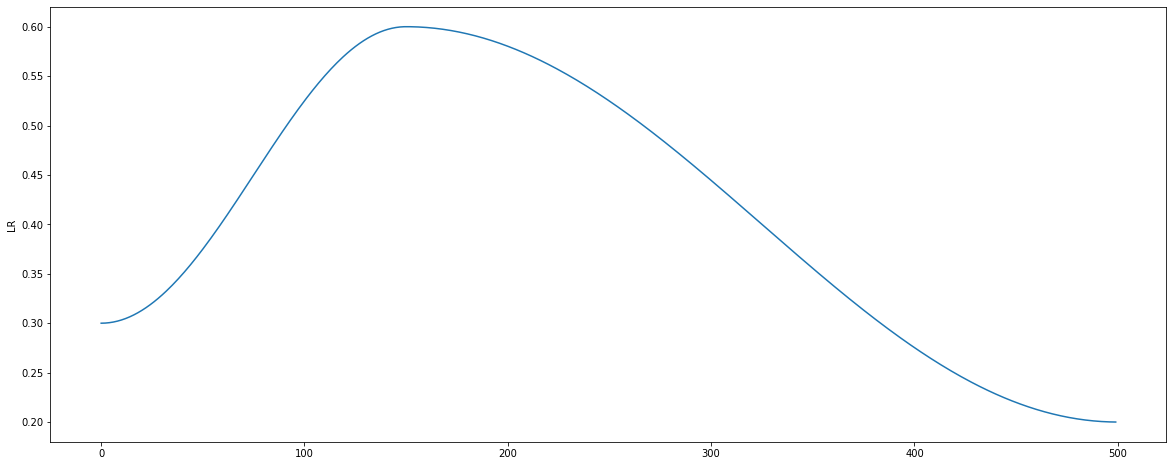

In [3]:
lr = []

for i in range(500):
    v = sched(i/500)
    lr.append(v)

plt.figure(figsize=(20, 8))
plt.plot(lr)
plt.ylabel('LR')
plt.show()

In [4]:
class OneCyclePolicy(object):
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 cycle_steps=None,
                 pct_warm=0.3,
                 max_lr=1e-3,
                 base_mom=0.85,
                 max_mom=0.95,
                 start_div_factor=25.0,
                 end_div_factor=10000.0):
        self.optimizer = optimizer
        self.cycle_steps = cycle_steps
        self.pct_warm = pct_warm
        self.max_lr = max_lr
        self.start_div_factor = start_div_factor
        self.end_div_factor = end_div_factor
        self.base_mom = base_mom
        self.max_mom = max_mom
        
        phases = [pct_warm, 1. - pct_warm]
        self.lr_schedule = combine_scheds(phases, 
                                          [sched_cos(max_lr / start_div_factor, max_lr), 
                                           sched_cos(max_lr, max_lr / end_div_factor)])
        
        self.mom_schedule = combine_scheds(phases, 
                                           [sched_lin(max_mom, base_mom), 
                                            sched_lin(base_mom, max_mom)])
        
        if "momentum" in optimizer.defaults:
            self.mom_field = "momentum"
        elif "betas" in optimizer.defaults:
            self.mom_field = "betas.0"
        else:
            self.mom_field = None
    
    def cur_pos(self, step: int):
        cur_step = step - (step // self.cycle_steps) * self.cycle_steps
        return cur_step / self.cycle_steps

    def step(self, epoch: int) -> None:
        pass

    def step_update(self, step: int) -> None:
        t = self.cur_pos(step)
        lr = self.lr_schedule(t)
        mom = self.mom_schedule(t)
        self.update_params(lr, "lr")
        self.update_params(mom, self.mom_field)

    def update_params(self, values, field: str):
        if not isinstance(values, (list, tuple)):
            values = [values] * len(self.optimizer.param_groups)
            
        fields = field.split(".")
        if len(fields) > 1:
            field, idx = fields
            idx = int(idx)
            def _upd(group, val):
                vals = list(group[field])
                vals[idx] = val
                group[field] = tuple(vals)
        else:
            def _upd(group, val): 
                group[field] = val
            
        for param_group, value in zip(self.optimizer.param_groups, values):
            _upd(param_group, value)

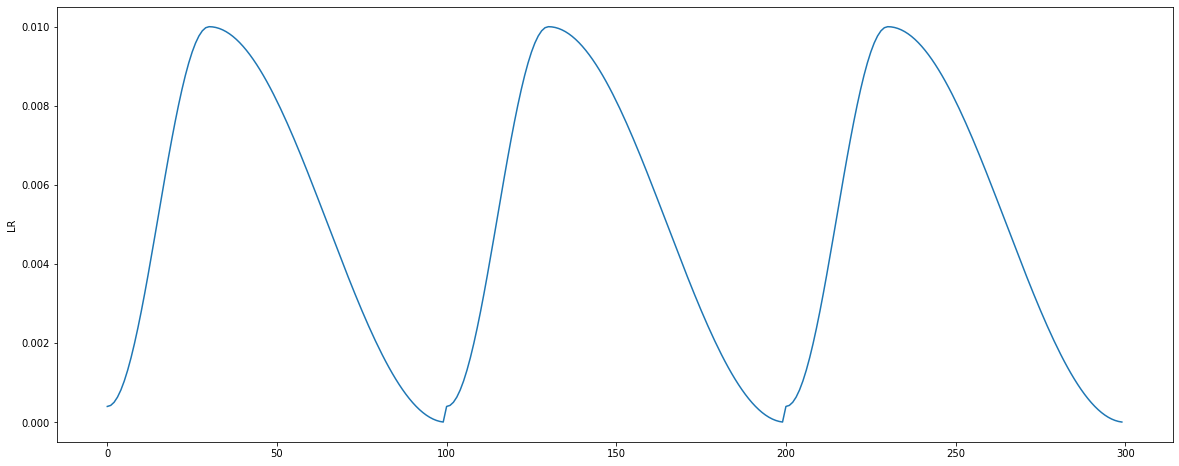

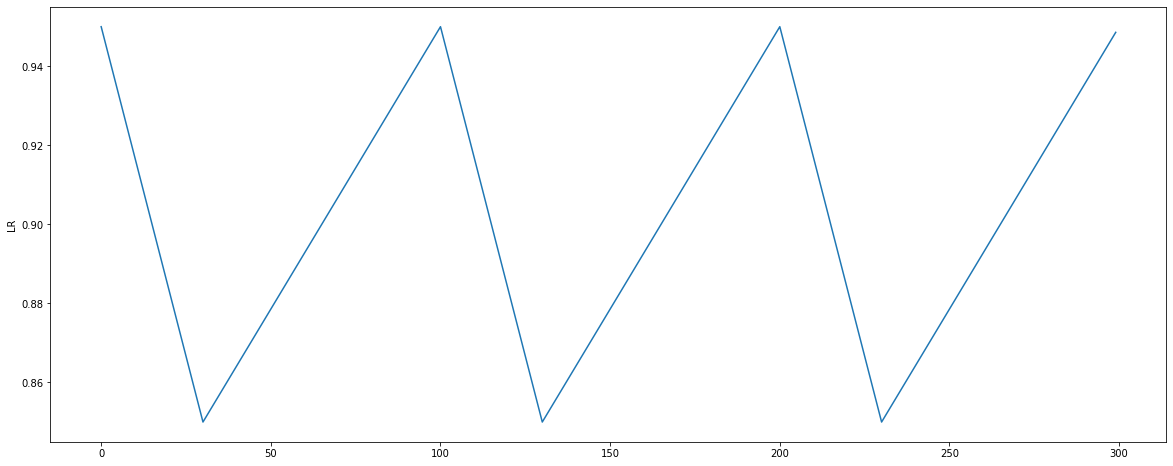

In [5]:
p = nn.Parameter(torch.empty(10, 10))
# optim = torch.optim.SGD([p], 0.01, momentum=0.9)
optim = torch.optim.AdamW([p], 0.01)

scheduler = OneCyclePolicy(optim, cycle_steps=100, max_lr=0.01)

epochs = 3
epoch_len = 100

lrs = []
moms = []

for e in range(epochs):
    for it in range(epoch_len):
        i = it + e * epoch_len
        scheduler.step_update(i)
        
        g = optim.param_groups[0]
        lrs.append(g['lr'])
        moms.append(g['betas'][0])

plt.figure(figsize=(20, 8))
plt.plot(lrs)
plt.ylabel('LR')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(moms)
plt.ylabel('LR')
plt.show()